# SIEM Development Notebook

- Wilson Tang, Xuemin Zhu, Hu Zhen 

In [137]:
import graspy 
from graspy.simulations import sbm, er_nm, er_np
from graspy.plot import heatmap
from scipy.stats import bernoulli 
import pandas as pd 
import matplotlib as plt 
import numpy as np 


%matplotlib inline

In [155]:
def siem(n, p,edge_comm, directed=False, loops=False, wt=None, wtargs=None):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    Examples
    --------
    >>> np.random.seed(1)
    >>> n = [3, 3]
    >>> p = [[0.5, 0.1], [0.1, 0.5]]
    To sample a binary 2-block SBM graph:
    >>> sbm(n, p)
    array([[0., 0., 1., 0., 0., 0.],
           [0., 0., 1., 0., 0., 1.],
           [1., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0., 0.],
           [0., 1., 0., 0., 0., 0.]])
    To sample a weighted 2-block SBM graph with Poisson(2) distribution:
    >>> wt = np.random.poisson
    >>> wtargs = dict(lam=2)
    >>> sbm(n, p, wt=wt, wtargs=wtargs)
    array([[0., 4., 0., 1., 0., 0.],
           [4., 0., 0., 0., 0., 2.],
           [0., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 2., 0., 0., 0., 0.]])
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))
#     #go by edge community for a 3-d np.array example
#     for i in range(0, K):
#         #sample bernoulli at once
#         rvs = bernoulli.rvs(p[i],size = len(edge_comm[i,:]))
#         #iterate over each index
#         for x in range(len(edge_comm[i,:])):
#             #set each equal to bernoulli 
#             A[tuple(edge_comm[i,x])] = rvs[x]
#             #adjust adjacency matrix with any weight args. 
#             if (wt is not None) and (wtargs is not None): 
#                     A[tuple(edge_comm[i,x])] = A[tuple(edge_comm[i,x])]*wt[i](**wtargs[i])

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
        
    return A

## Simulated Cases - Error Case Testing


### Case 1: N isn't an Integer

In [65]:
n = 3.5
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
wt = np.random.poisson
wtargs = dict(lam=2)
siem(n, p, edge_comm = k, directed=True, loops=True, wt=wt, wtargs=wtargs)

TypeError: n must be a int, not <class 'float'>.

## Case 2: Edge Communities

### Case 2.1: Edge Community isn't a list

In [68]:
n = 4
p = [0.5,0.5]
k = np.array([[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]])
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

TypeError: edge_comm must be a 2d list of length k.

### Case 2.2: Check the element in the edge community is a 2-element tuple

In [69]:
n = 4
p = [0.5,0.5]
k = [[[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3]],[[2,0],[2,1],[2,2],[2,3],[3,0],[3,1],[3,2],[3,3]]]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

TypeError: The edge_comm list must contain tuples of 2 elements.

### Case 2.3: Check the situation if the directed = True and the loop = True

In [71]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2)]]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

ValueError: Edge Communities and Number of Vertices Do Not Agree!

### Case 2.4: Check the situation if the directed = True and the loop = False

In [156]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
siem(n, p, edge_comm = k, directed=True, loops=False, wt=None, wtargs=None)

ValueError: Edge Communities and Number of Vertices Do Not Agree, 16 must be <= n(n-1)/2!

### Case 2.4: Check the situation if the directed = False and the loop = True

In [157]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
siem(n, p, edge_comm = k, directed=False, loops=True, wt=None, wtargs=None)

ValueError: Edge Communities and Number of Vertices Do Not Agree, 16 must be <= n(n-1)!

# Case 3: Check P

## Case 3.1  Check whether p is a list or not

In [158]:
n = 4
p = {0.5,0.5}
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

TypeError: p must be a list or np.array, not <class 'set'>.

### Case 3.2 Check whether the element in p is number or not

In [148]:
n = 4
p = [{0.5},{0.5}]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

ValueError: There are non-numeric elements in p

### Case 3.3 Check whether p is between 0 and 1

In [149]:
n = 4
p = [1.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

ValueError: Values in p must be in between 0 and 1.

### Case 3.4: Check whether # of Probabilities and # of Communities are the same

In [159]:
n = 4
p = [0.5,0.5,0.3]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=None, wtargs=None)

ValueError: # of Probabilities and # of Communities Don't Match Up

# Case 4: Check wt and wtargs

### Case 4.1 Check if wt is a callable object

In [152]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
wt = 1
wtargs = dict(lam=2)
siem(n, p, edge_comm = k, directed=True, loops=True, wt=wt, wtargs=wtargs)

ValueError: wt must be a callable object or list of callable objects

# Case 4.2: Check if each element in wt(list) is object

In [153]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
wt = [0.3,np.random.poisson]
wtargs = dict(lam=2)
siem(n, p, edge_comm = k, directed=True, loops=True, wt=wt, wtargs=wtargs)

ValueError: list must contain all callable objects

# Case 4.3: Check if # wt = k

In [160]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
wt = [np.random.poisson,np.random.poisson,np.random.poisson]
wtargs = dict(lam=2)
siem(n, p, edge_comm = k, directed=True, loops=True, wt=wt, wtargs=wtargs)

ValueError: wt must have size k, not 3

### Case 4.4: Check if # wtargs = K

In [161]:
n = 4
p = [0.5,0.5]
k = [[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)],[(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]]
wt = [np.random.poisson,np.random.poisson]
wtargs = [dict(lam=2)]
siem(n, p, edge_comm = k, directed=True, loops=True, wt=wt, wtargs=wtargs)

ValueError: wtargs must have size k , not 1

# Simulated Cases - Various Adjacency Matrix Heatmaps

## 1 Community Case Replicating ER graph with SIEM

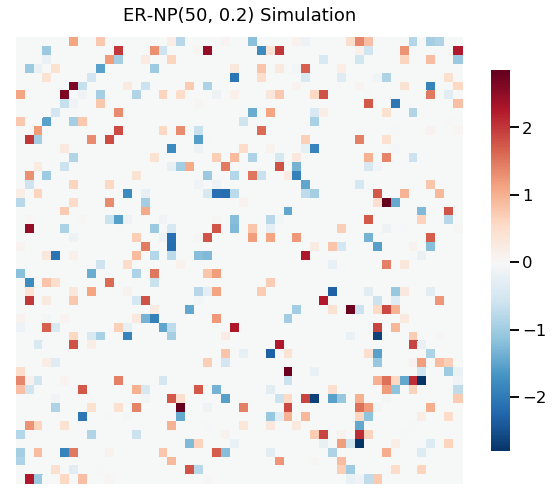

In [139]:
n = 50
#m = 250
p = 0.3
np.random.seed(1)
G1 = er_np(n=n, p=p)
wt = np.random.normal
wtargs = dict(loc=0, scale=1)
G1 = er_np(n=50, p=0.2, wt = wt, wtargs = wtargs)
heatmap(G1, title = 'ER-NP(50, 0.2) Simulation')

<class 'tuple'>
(2500, 2)


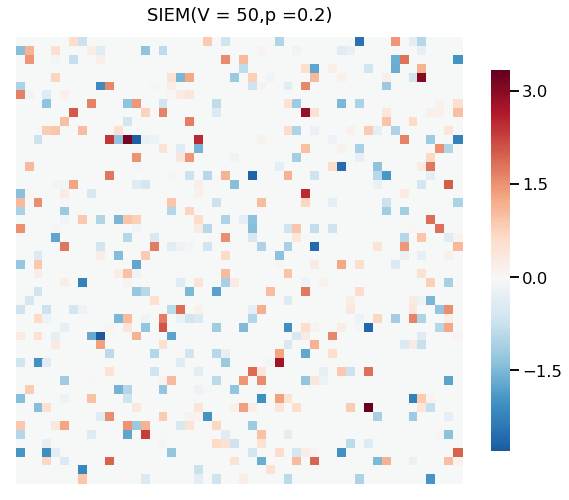

In [134]:
a=[]
for i in range(50): 
    for j in range(50): 
        a.append((i,j))
#print(a)
print(type(a[1]))
print(np.array(a).shape)
wt = np.random.normal
wtargs = dict(loc=0, scale=1)
S1=siem(n=50, p=[0.2],edge_comm=[a], directed=True, loops=True, wt=wt, wtargs=wtargs)
heatmap(S1,title='SIEM(V = 50,p =0.2)')

We can see that the graphs are very similar, the difference can be attributed to differences in the initial sampling distribution: (ER uses uniform while SIEM uses bernoulli)

## 2 community Case Replicating SBM with V = 100, 50 vertex communities, P = 0.5, Q = 0.1 with SIEM

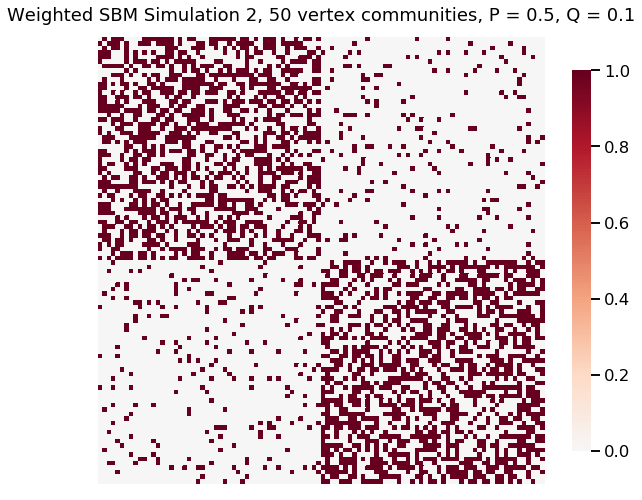

In [15]:
n= [50,50]
p = [[0.5,0.1],[0.1,0.5]]
wt = 1
G2 = sbm(n= n, p=p)
heatmap(G2,title = 'Weighted SBM Simulation 2, 50 vertex communities, P = 0.5, Q = 0.1')

In [130]:
edge_comm_1 = np.argwhere(G2[:50,:50]==1)
edge_comm_2 = np.argwhere(G2[50:,50:]==1) + 50
edge_comm = []
comms = [edge_comm_1,edge_comm_2]
for i in comms:
    edge_comm_list = []
    for x in range(len(i)):
        edge_comm_list.append(tuple(i[x]))
    edge_comm.append(edge_comm_list)
    

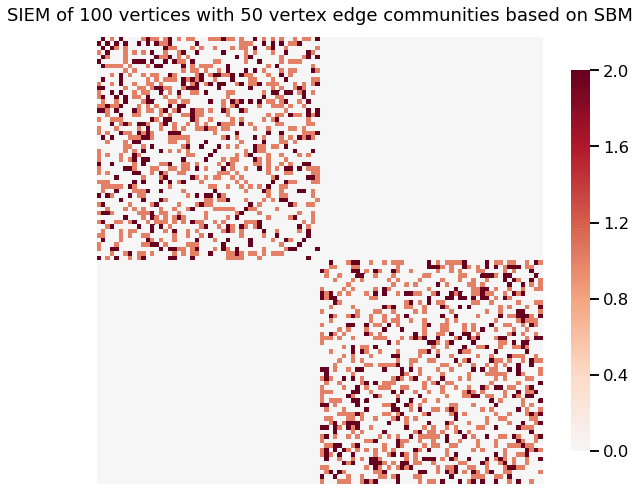

In [142]:
n = 100 
p = [0.5,0.5]

S1 = siem(n=n , p=p, directed = False, loops = False, edge_comm = edge_comm)
heatmap(S1, title= 'SIEM of 100 vertices with 50 vertex edge communities based on SBM')


As we expect the adjacnecy matrix is only replicated for the edges since there are 2 communities and only those edges were provided.

## Case of Matching Pair of Interest

100 Vertices, Vertices [i,i], [i,50 + i], [50+i, i] are in teh same community, i = 1 ... 50. (that is, for instance, each vertex has a "matching pair" of interest, the edge corresponding to [1,51], [51,1], [2,52] , [52,2] ...)

[[(0, 0), (0, 50), (50, 0)], [(1, 1), (1, 51), (51, 1)], [(2, 2), (2, 52), (52, 2)], [(3, 3), (3, 53), (53, 3)], [(4, 4), (4, 54), (54, 4)], [(5, 5), (5, 55), (55, 5)], [(6, 6), (6, 56), (56, 6)], [(7, 7), (7, 57), (57, 7)], [(8, 8), (8, 58), (58, 8)], [(9, 9), (9, 59), (59, 9)], [(10, 10), (10, 60), (60, 10)], [(11, 11), (11, 61), (61, 11)], [(12, 12), (12, 62), (62, 12)], [(13, 13), (13, 63), (63, 13)], [(14, 14), (14, 64), (64, 14)], [(15, 15), (15, 65), (65, 15)], [(16, 16), (16, 66), (66, 16)], [(17, 17), (17, 67), (67, 17)], [(18, 18), (18, 68), (68, 18)], [(19, 19), (19, 69), (69, 19)], [(20, 20), (20, 70), (70, 20)], [(21, 21), (21, 71), (71, 21)], [(22, 22), (22, 72), (72, 22)], [(23, 23), (23, 73), (73, 23)], [(24, 24), (24, 74), (74, 24)], [(25, 25), (25, 75), (75, 25)], [(26, 26), (26, 76), (76, 26)], [(27, 27), (27, 77), (77, 27)], [(28, 28), (28, 78), (78, 28)], [(29, 29), (29, 79), (79, 29)], [(30, 30), (30, 80), (80, 30)], [(31, 31), (31, 81), (81, 31)], [(32, 32), (32,

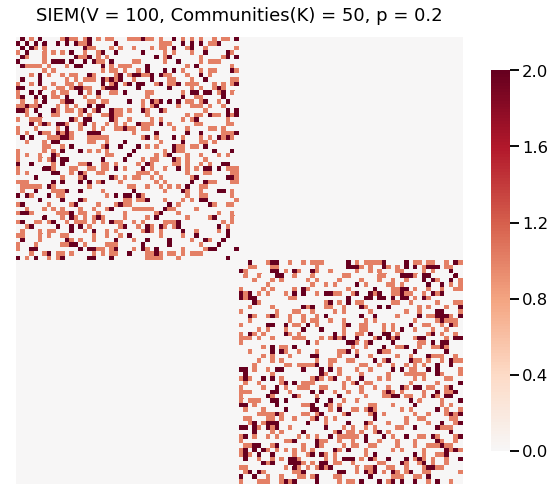

In [146]:
n=100
b=[]
for i in range(50): 
    b.append([])
    b[i].append((i,i))
    b[i].append((i,50+i))
    b[i].append((50+i,i))
tuple(b)  
print(b)
print(np.array(b).size)
S2=siem(n=100, p=[0.2]*50,edge_comm=b, directed=True, loops=True, wt=None, wtargs=None)
heatmap(S1,title='SIEM(V = 100, Communities(K) = 50, p = 0.2')

As we expect, the adjacnecy matrix is only replicated for the edges-edge communities since we provided it with edges within community only